In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             root_mean_squared_error)
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
df = pd.read_csv("/content/daily_revenue.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True)

In [5]:
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [6]:
# Preview df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [7]:

df['revenue'] = df['revenue'].str.replace(",","").astype(float)
df = df.rename(columns={'revenue': 'y'})

In [8]:
df = df.asfreq("D")

a list of commonly used .asfreq() aliases:
Time-based frequencies:


*   D: calender day frequency
*   B: business day frequency
*   W: weekly frequency
*   W-MON: Weekly frequency (anchored on a specific day)
*   ME: Month end frequency
*   MS: Month start frequency
*   Q: Quarter start frequency
*   QS: Quarter start frequency
*   A or Y: Year end frequency
*   BA or BY: Business year start frequency
*   AS or YS: Year start frequency
*   BAS or BYS: Business year start frequency

*   H: Hourly
*   T or min: Minute
*   S: Second

*   2D: every 2 days
*   4H: every 4 hours
*   15T: every 15 minutes


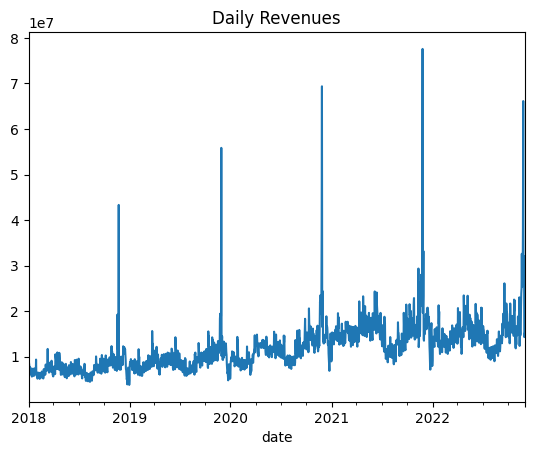

In [9]:
df['y'].plot(title = 'Daily Revenues')
plt.show()


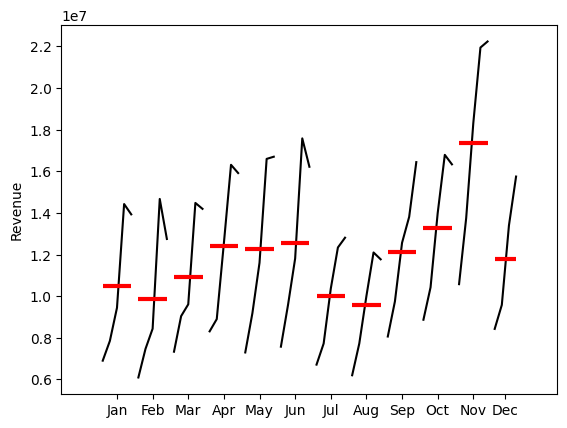

In [10]:
month_plot(df['y'].resample('ME').mean(), ylabel='Revenue')
plt.show()

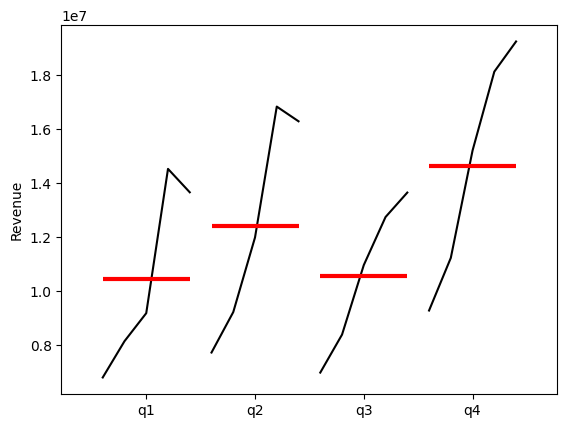

In [11]:
quarter_plot(df['y'].resample('QE').mean(), ylabel='Revenue')
plt.show()

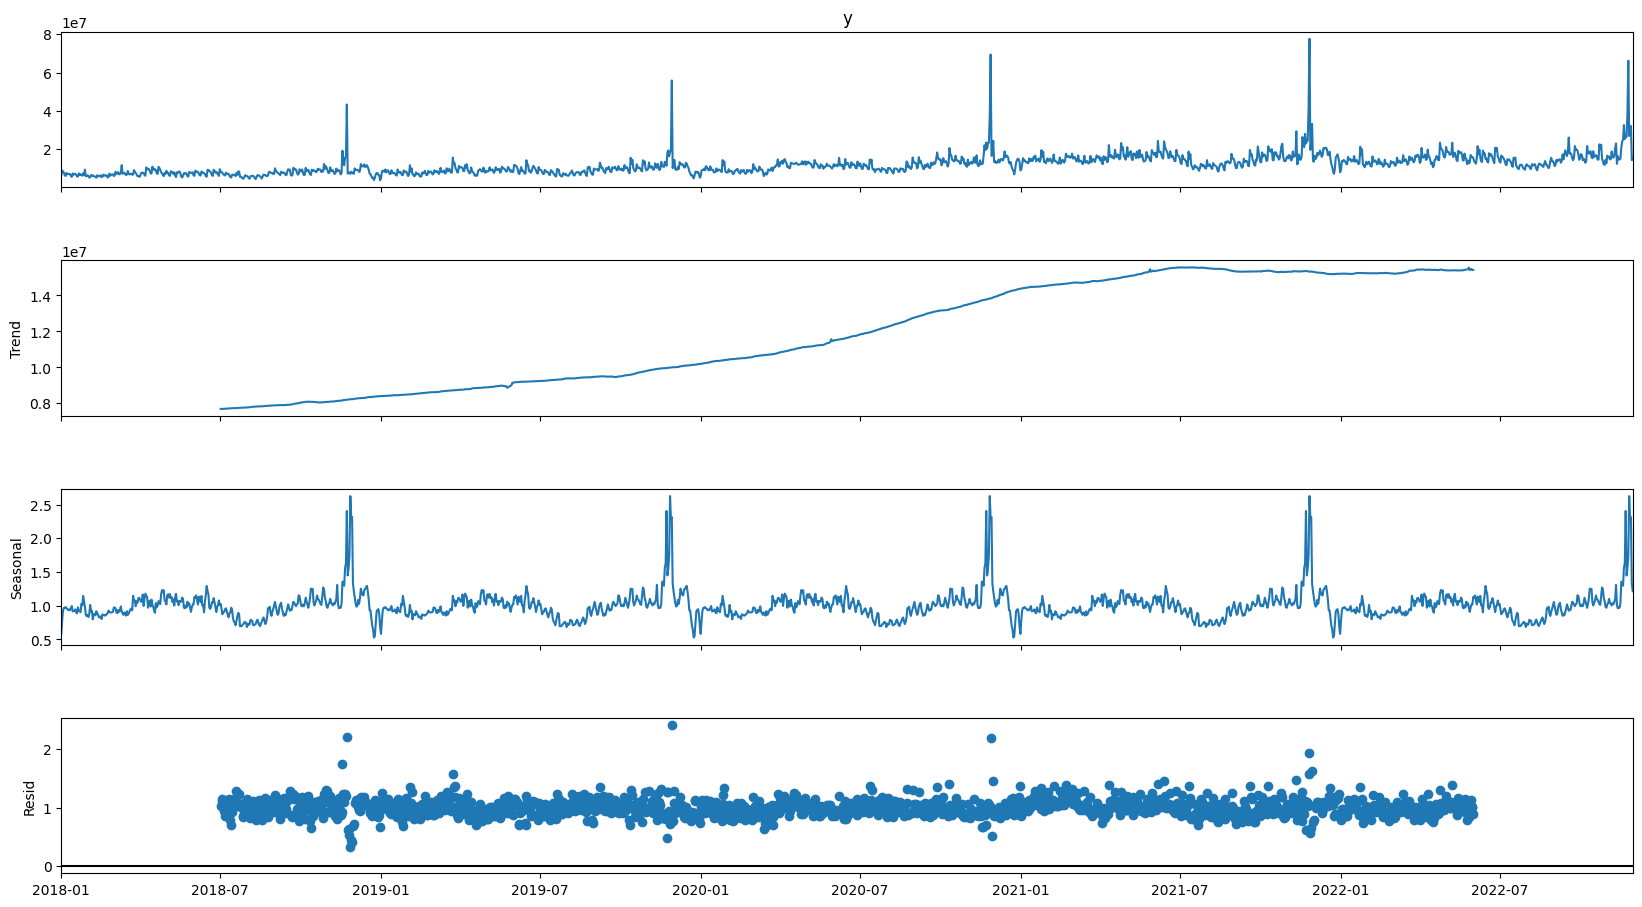

In [12]:
# seasonal decomposition
decomposition = seasonal_decompose(df['y']
                                   , model = 'mul'
                                   , period = 365)
fig=decomposition.plot()
fig.set_size_inches(18,10)
plt.show()

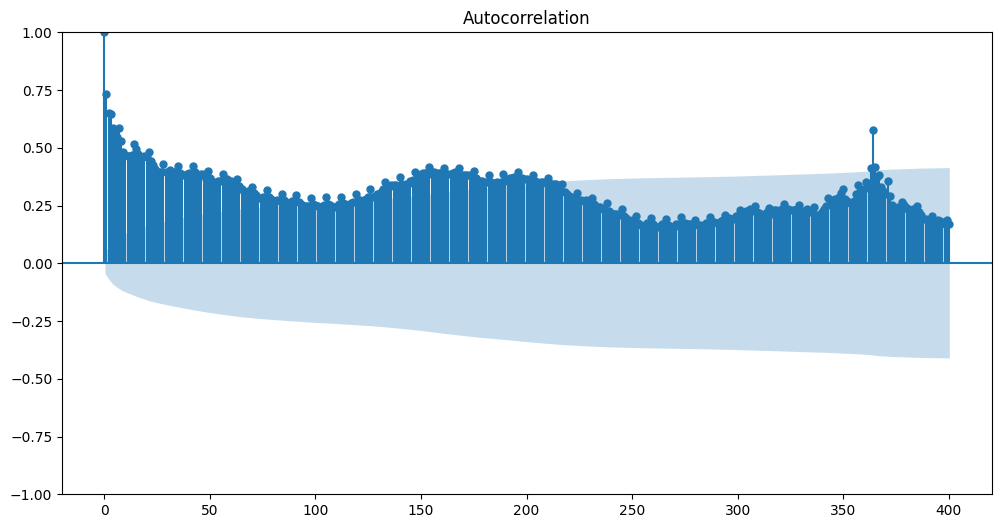

In [13]:
# Plot the ACF - autocorelation of y
fig, ax = plt.subplots(figsize = (12, 6))
plot_acf(df['y'], lags = 400, ax = ax)
plt.show()

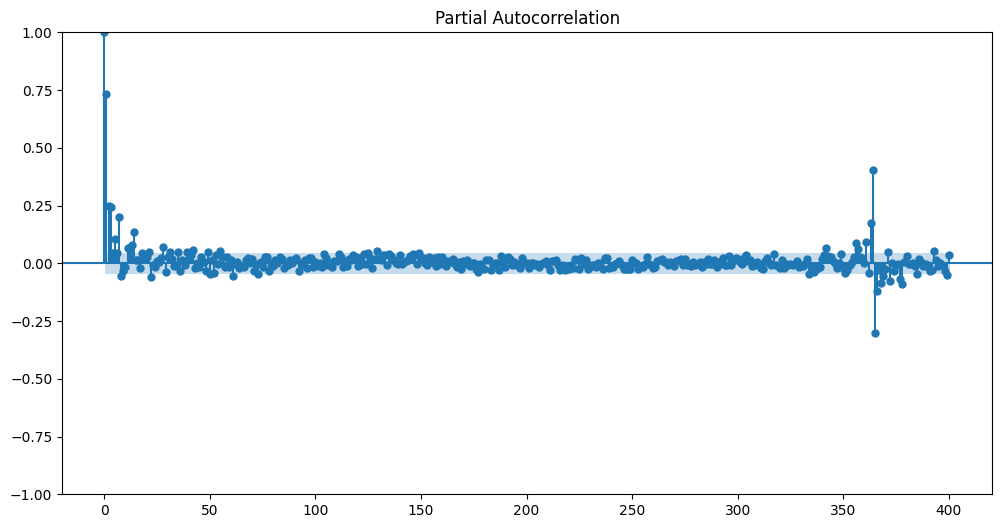

In [14]:

# PACF for y  (the higher the bar, the more relevance)
fig, ax = plt.subplots(figsize = (12, 6))
plot_pacf(df['y'], lags = 400, ax = ax)
plt.show()

# Stationarity

The null hypothesis is that time series is not stationary if p-value is above 0.05

In [15]:
result =adfuller(df.y)
print(f"p-value:{result[1]}")
if result[1]>0.05:
  print("The time series is not stationary")
else:
  print("The time series is stationary")

p-value:0.10190360862386194
The time series is not stationary


In [16]:
df['y_diff'] = df['y'].diff()
df.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27%,1.09%,NaN
2018-01-02,8922076.0,30.87%,1.08%,2651237.0
2018-01-03,8446101.0,28.11%,1.01%,-475975.0
2018-01-04,7785798.0,27.32%,0.96%,-660303.0
2018-01-05,6375303.0,25.70%,0.90%,-1410495.0


In [17]:
# Test if the difference time series is stationary
result =adfuller(df.y_diff.dropna())
print(f"p-value:{result[1]}")
if result[1]>0.05:
  print("The time series is not stationary")
else:
  print("The time series is stationary")

p-value:6.5137920268184015e-24
The time series is stationary


ARIMA

In [18]:
# Split the data into training and test
test_days = 30
train = df.iloc[:-test_days]
test = df.iloc[-test_days:]
test.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2022-11-01,16703680.0,23.85%,1.50%,4014654.0
2022-11-02,15827022.0,20.76%,0.94%,-876658.0
2022-11-03,16154319.0,21.85%,0.92%,327297.0
2022-11-04,14707212.0,20.17%,0.88%,-1447107.0
2022-11-05,14877530.0,17.85%,0.41%,170318.0


In [19]:
# Create the ARIMA model
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
model = SARIMAX(train['y'], order = (3, 1, 1),
                # uses the value from the previous 3 time periods to predict current value
                # 1 differencing (current - prior)
                # uses the residual error from 1 prior day to correct the current forecast
                seasonal_order = (0,0,0,0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -28828.653
Date:                Sun, 28 Sep 2025   AIC                          57667.306
Time:                        15:56:53   BIC                          57694.682
Sample:                    01-01-2018   HQIC                         57677.422
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3563      0.014     24.733      0.000       0.328       0.385
ar.L2          0.0237      0.020      1.195      0.232      -0.015       0.062
ar.L3          0.1274      0.022      5.804      0.0

In [20]:
# Predict with the ARIMA model
predictions = model.forecast(steps = test_days)
predictions

,predicted_mean
2022-11-01,1.412691e+07
2022-11-02,1.494030e+07
2022-11-03,1.502568e+07
2022-11-04,1.525848e+07
2022-11-05,1.544705e+07
2022-11-06,1.553061e+07
2022-11-07,1.559450e+07
2022-11-08,1.564325e+07
2022-11-09,1.567278e+07
2022-11-10,1.569259e+07


In [21]:
# Function the assesses the model and visualizes the train, test and forecast
def model_assessment(train, test, predictions, chart_title=None):
  plt.figure(figsize = (10,4))
  # Plot the train, test and forecast data
  plt.plot(train, label = 'Train', color = 'blue')
  plt.plot(test, label = 'Test', color = 'orange')
  plt.plot(predictions, label = 'Forecast', color = 'green')
  plt.title(chart_title)
  plt.legend()
  plt.show()
  # Calculate and print the RMSE, MAE and MAPE
  rmse = root_mean_squared_error(test, predictions)
  mae = mean_absolute_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)
  print(f'RMSE: {rmse:.0f}')
  print(f'MAE: {mae:.0f}')
  print(f'MAPE: {100 * mape:.1f} %')

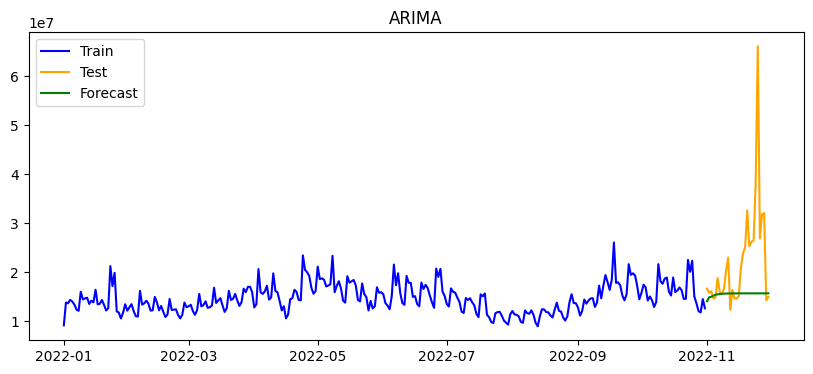

RMSE: 12374873
MAE: 7276324
MAPE: 24.2 %


In [22]:
model_assessment(train['y']['2022'], test['y'],predictions, 'ARIMA')

SARIMA

In [23]:
# Create the SARIMA model
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
model_sarima = SARIMAX(train['y'], order = (3, 1, 1), # average of previous 3 days , error of previous 1 day
                seasonal_order = (2,0,1,7)).fit() # 4 is quarterly, 12 is monthly
                # 2: the model includes 2 past seasonal periods to predict the current value (correlation with the value 1 year ago and 2 year ago)
                # 0, no seasonal trend differencing; seasonal trend is assumed to be stable over time or trend has been removed
                # 1: the model includes 1 seasonal lagged forecast error (forecast error from last year to correct the current)
                # 365: seasonal cycle that repeats every 365 observations
print(model_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -28738.555
Date:                           Sun, 28 Sep 2025   AIC                          57493.109
Time:                                   15:56:57   BIC                          57536.912
Sample:                               01-01-2018   HQIC                         57509.295
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4391      0.008     58.398      0.000       0.424       0.454
ar.L2          0.0600      0.015      4.039

In [24]:
# Predict with the ARIMA model
predictions_s = model_sarima.forecast(steps = test_days)
predictions_s

,predicted_mean
2022-11-01,1.442935e+07
2022-11-02,1.378786e+07
2022-11-03,1.338803e+07
2022-11-04,1.270744e+07
2022-11-05,1.267486e+07
2022-11-06,1.633093e+07
2022-11-07,1.520626e+07
2022-11-08,1.549579e+07
2022-11-09,1.514123e+07
2022-11-10,1.475336e+07


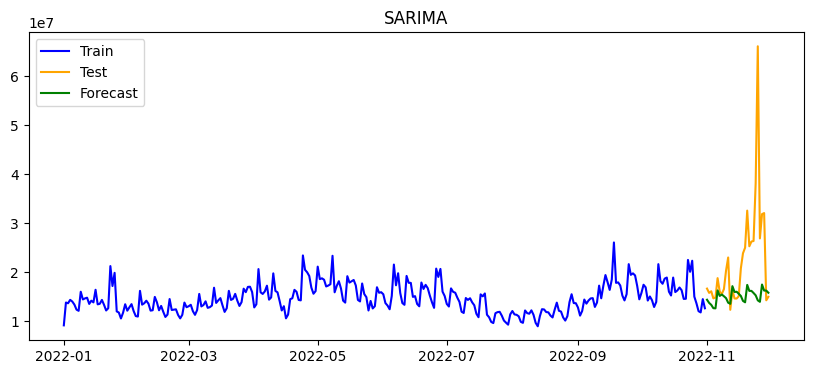

RMSE: 12609056
MAE: 7610966
MAPE: 25.9 %


In [25]:
model_assessment(train['y']['2022'], test['y'],predictions_s, 'SARIMA')

SARIMAX

In [26]:
# remove the % symbol from discount rate and coupon_rate columns and convert to float
df['discount_rate'] = df['discount_rate'].str.replace('%','').astype(float)
df['coupon_rate'] = df['coupon_rate'].str.replace('%','').astype(float)

In [27]:
df.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27,1.09,NaN
2018-01-02,8922076.0,30.87,1.08,2651237.0
2018-01-03,8446101.0,28.11,1.01,-475975.0
2018-01-04,7785798.0,27.32,0.96,-660303.0
2018-01-05,6375303.0,25.70,0.90,-1410495.0


In [28]:
# Split the regressor data into train and test
# start from 0 and end at all - test_days
train_reg = df[['discount_rate',"coupon_rate"]][:-test_days]
# start with all - test days and end at the last row
test_reg = df[['discount_rate',"coupon_rate"]][-test_days:]

In [29]:
# Create the SARIMAX model
# X - exogenous factors (external factors)
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
model_sarimax = SARIMAX(train['y'],
                        order = (3, 1, 1), # average of previous 3 days , error of previous 1 day
                        exog = train_reg,
                        seasonal_order = (2,0,1,7),
                        ).fit() # 4 is quarterly, 12 is monthly
                # 2: the model includes 2 past seasonal periods to predict the current value (correlation with the value 1 year ago and 2 year ago)
                # 0, no seasonal trend differencing; seasonal trend is assumed to be stable over time or trend has been removed
                # 1: the model includes 1 seasonal lagged forecast error (forecast error from last year to correct the current)
                # 365: seasonal cycle that repeats every 365 observations
print(model_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -28595.060
Date:                           Sun, 28 Sep 2025   AIC                          57210.121
Time:                                   15:57:05   BIC                          57264.874
Sample:                               01-01-2018   HQIC                         57230.353
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
discount_rate   4.03e+05   1.55e-08   2.59e+13      0.000    4.03e+05    4.03e+05
coupon_rate    9.229e+05   7.46e-0

In [30]:
# Predict with the SARIMAX model
predictions_sx = model_sarimax.forecast(steps = test_days,
                                        exog=test_reg)
predictions_sx

,predicted_mean
2022-11-01,1.661406e+07
2022-11-02,1.488058e+07
2022-11-03,1.477119e+07
2022-11-04,1.319489e+07
2022-11-05,1.156737e+07
2022-11-06,1.379562e+07
2022-11-07,1.305409e+07
2022-11-08,1.289476e+07
2022-11-09,1.412413e+07
2022-11-10,2.049049e+07


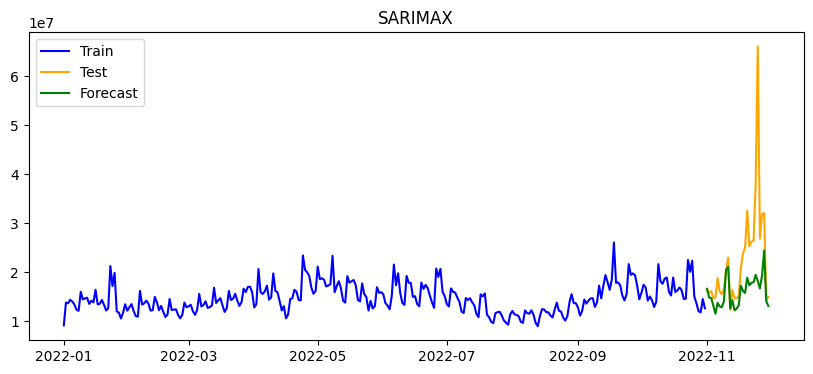

RMSE: 10955476
MAE: 6305435
MAPE: 21.7 %


In [31]:
model_assessment(train['y']['2022'], test['y'],predictions_sx, 'SARIMAX')

In [32]:
# the model sets weekly seasonality.
# it misses yearly seasonality ( chirstmas etc). add more variable abouot it

# Cross-Validation
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [33]:
# Define the configurations
order = (3,1,1)
seasonal_order = (2,0,1,7)
n_splits = 5

In [34]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits, test_size = test_days)

In [35]:
# inspect the time series splits
for train_index, test_index in tscv.split(df):
  print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [   0    1    2 ... 1642 1643 1644] TEST: [1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658
 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672
 1673 1674]
TRAIN: [   0    1    2 ... 1672 1673 1674] TEST: [1675 1676 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687 1688
 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701 1702
 1703 1704]
TRAIN: [   0    1    2 ... 1702 1703 1704] TEST: [1705 1706 1707 1708 1709 1710 1711 1712 1713 1714 1715 1716 1717 1718
 1719 1720 1721 1722 1723 1724 1725 1726 1727 1728 1729 1730 1731 1732
 1733 1734]
TRAIN: [   0    1    2 ... 1732 1733 1734] TEST: [1735 1736 1737 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748
 1749 1750 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762
 1763 1764]
TRAIN: [   0    1    2 ... 1762 1763 1764] TEST: [1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778
 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 17

In [36]:
len(df)

1795

In [37]:
# perform the time series CV and assess based on RMSE, MAE and MAPE
cv_scores = []
for train_index, test_index in tscv.split(df):
  train = df.iloc[train_index]
  test = df.iloc[test_index]
  train_reg = df[['discount_rate',"coupon_rate"]].iloc[train_index]
  test_reg = df[['discount_rate',"coupon_rate"]].iloc[test_index]
# Build the SARIMAX
  model_sarimax = SARIMAX(train['y'],
                          exog = train_reg,
                          order = order,
                          seasonal_order = seasonal_order).fit()
  predictions_sx = model_sarimax.forecast(steps = test_days,
                                          exog=test_reg)
  rmse = root_mean_squared_error(test['y'], predictions_sx)
  mae = mean_absolute_error(test['y'], predictions_sx)
  mape = mean_absolute_percentage_error(test['y'], predictions_sx)
  cv_scores.append({'RMSE': rmse, 'MAE': mae, 'MAPE': mape})

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
# Aggregate and display the results
cv_scores = pd.DataFrame(cv_scores)
cv_scores.index.name = 'Fold'
cv_scores

,RMSE,MAE,MAPE
Fold,,,
0,2.664699e+06,2.466156e+06,0.210036
1,1.067887e+06,7.420534e+05,0.060822
2,4.876607e+06,4.282031e+06,0.246532
3,3.073594e+06,2.668263e+06,0.180545
4,1.095548e+07,6.305435e+06,0.217099


In [39]:
# Print the average errors
print(f'Average RMSE: {cv_scores["RMSE"].mean():.2f}')
print(f'Average MAE: {cv_scores["MAE"].mean():.2f}')
print(f'Average MAPE: {cv_scores["MAPE"].mean():.2f}')

Average RMSE: 4527652.60
Average MAE: 3292787.66
Average MAPE: 0.18


# Parameter Tuning

In [40]:
# Define the parameter options
param_grid = {
    'p': [1,3],
    'd': [0],
    'q': [0,1],
    'P': [1,2],
    'D': [0],
    'Q': [1]
}
grid = ParameterGrid(param_grid)
list(grid)

[{'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 1, 'q': 0},
 {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 1, 'q': 1},
 {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 3, 'q': 0},
 {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 3, 'q': 1},
 {'D': 0, 'P': 2, 'Q': 1, 'd': 0, 'p': 1, 'q': 0},
 {'D': 0, 'P': 2, 'Q': 1, 'd': 0, 'p': 1, 'q': 1},
 {'D': 0, 'P': 2, 'Q': 1, 'd': 0, 'p': 3, 'q': 0},
 {'D': 0, 'P': 2, 'Q': 1, 'd': 0, 'p': 3, 'q': 1}]

In [41]:
# Time Series Splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size = test_days)


In [44]:
# Perform the parameter tuning
rmse_list = []

# Iterate over the parameters:
for params in grid:
  fold_rmse = []
  # Build the model
  for train_index, test_index in tscv.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    # Isolate the regressors
    train_reg = df[['discount_rate',"coupon_rate"]].iloc[train_index]
    test_reg = df[['discount_rate',"coupon_rate"]].iloc[test_index]
 # SARIMAX Model
    model_sarimax = SARIMAX(train['y'],
                            exog = train_reg,
                            order = (params['p'],params['d'],params['q']),
                            seasonal_order = (params['P'],
                                              params['D'],params['Q'],7)).fit()
 # Calculate the error and store results
    predictions_sx = model_sarimax.forecast(steps = test_days,
                                            exog=test_reg)
    rmse = root_mean_squared_error(test['y'], predictions_sx)
    fold_rmse.append(rmse)
    rmse_list.append({'params': params,
                      'rmse': np.mean(fold_rmse)})

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [47]:
# Check the outputs
rmse_df = pd.DataFrame(rmse_list)
rmse_df.sort_values(by = 'rmse').head()

,params,rmse
36,"{'D': 0, 'P': 2, 'Q': 1, 'd': 0, 'p': 3, 'q': 1}",1.919385e+06
16,"{'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 3, 'q': 1}",1.942344e+06
1,"{'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 1, 'q': 0}",2.004243e+06
6,"{'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 1, 'q': 1}",2.155829e+06
21,"{'D': 0, 'P': 2, 'Q': 1, 'd': 0, 'p': 1, 'q': 0}",2.170619e+06


In [49]:
best_params = rmse_df.loc[rmse_df['rmse'].idxmin()]
best_params

,36
params,"{'D': 0, 'P': 2, 'Q': 1, 'd': 0, 'p': 3, 'q': 1}"
rmse,1919385.450888


# Predict the future

In [61]:
# Isolate X and y
X_future = df[['discount_rate',"coupon_rate"]]
y = df['y']


In [70]:
X_future.tail()

,discount_rate,coupon_rate
date,,
2022-11-26,30.41,0.38
2022-11-27,29.75,0.35
2022-11-28,25.27,8.93
2022-11-29,19.54,0.26
2022-11-30,17.10,0.32


In [53]:
# Fetch the best parameters
p = int(best_params['params']['p'])
d = int(best_params['params']['d'])
q = int(best_params['params']['q'])
P = int(best_params['params']['P'])
D = int(best_params['params']['D'])
Q = int(best_params['params']['Q'])

In [58]:
future_reg = pd.read_csv("/content/future_regressors.csv",
                         index_col=0,
                         dayfirst=True,
                         parse_dates=True) # make sure column 0 is correctly converted into a DatetimeIndex
future_reg.head()

,revenue,discount_rate,coupon_rate,discount_rate_lag1,coupon_rate_lag1
date,,,,,
2022-12-01,NaN,0.1831,0.0031,0.1710,0.0032
2022-12-02,NaN,0.1995,0.0036,0.1831,0.0031
2022-12-03,NaN,0.2029,0.0032,0.1995,0.0036
2022-12-04,NaN,0.1898,0.0030,0.2029,0.0032
2022-12-05,NaN,0.1810,0.0042,0.1898,0.0030


In [72]:
# Isolate future discount rate and coupon rate and multiply by 100
X_future = future_reg[['discount_rate','coupon_rate']] * 100
X_future.head()
#

,discount_rate,coupon_rate
date,,
2022-12-01,18.31,0.31
2022-12-02,19.95,0.36
2022-12-03,20.29,0.32
2022-12-04,18.98,0.30
2022-12-05,18.10,0.42


In [77]:
X_future.tail()

,discount_rate,coupon_rate
date,,
2022-12-27,29.32,6.09
2022-12-28,29.52,6.41
2022-12-29,28.98,0.48
2022-12-30,28.60,0.40
2022-12-31,29.01,0.72


In [59]:
# build the tuned SARIMAX model
model_sarimax = SARIMAX(y,
                        exog = X,
                        order = (p,d,q),
                        seasonal_order = (P,D,Q,7)).fit()
print(model_sarimax.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1795
Model:             SARIMAX(3, 0, 1)x(2, 0, 1, 7)   Log Likelihood              -29219.581
Date:                           Sun, 28 Sep 2025   AIC                          58459.162
Time:                                   16:27:28   BIC                          58514.089
Sample:                               01-01-2018   HQIC                         58479.440
                                    - 11-30-2022                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
discount_rate  5.964e+05   2.46e+04     24.240      0.000    5.48e+05    6.45e+05
coupon_rate    5.635e+05   3150.74

In [73]:
# Make the predictions
future_predictions = model_sarimax.forecast(steps = len(X_future),
                                            exog=X_future)
future_predictions

,predicted_mean
2022-12-01,1.994247e+07
2022-12-02,2.362495e+07
2022-12-03,2.031688e+07
2022-12-04,2.267020e+07
2022-12-05,2.119231e+07
2022-12-06,1.993313e+07
2022-12-07,2.018827e+07
2022-12-08,2.003965e+07
2022-12-09,1.906329e+07
2022-12-10,1.794851e+07


In [74]:
# build a chart function
def plot_future(y, forecast, chart_title=None):
  plt.figure(figsize = (10,4))
  plt.plot(y, label = 'Train', color = 'blue')
  plt.plot(forecast, label = 'Forecast', color = 'green')
  plt.title(chart_title)
  plt.legend()
  plt.show()

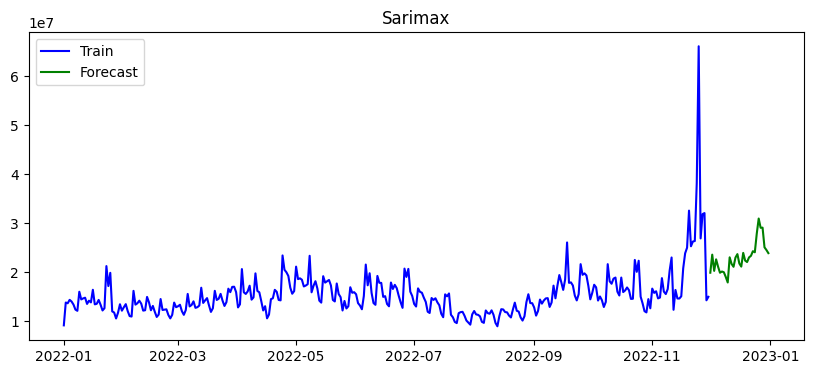

In [75]:
# plot the future predictions
plot_future(y['2022'], future_predictions, "Sarimax")